<h1 align="center">Deep learning a gyakorlatban Python és LUA alapon | VITMAV45</h1>
<h2 align="center">Nagy házi feladat</h2>

Team: Molehub

Team members:
* Küttel Dániel (QPPXW1) email:kutteljr@gmail.com
* Siket Máté (N1C4Z9) email:siket.mate@gmail.com


Topic: Mole detection with deep learning

<h2 align="center">I. milestone</h2>

### 1.1 Motivation
The current neural networks are developed for diagnose melanoma based on dermatoscopic images. On the other hand, during consultations we determined a different kind of approach. Our goal is to mark the moles on pictures which are taken from different distances at different angles, resolutions and lighting conditions. The "cutouts" could be later used for detailed investigation or mole appareance follow-up.

### 1.2 Main tasks during the semester
* Data acquistion & preprocess
* Train
* Data augmentation
* Hyperparameter tuning

Regarding the <i>I. milestone</i> our task is invloving data acquisiton, labeling, preprocessing standardization and in general to make an organized dataset which will be later applicable for training purposes.

### 1.3 Data acquistion & preprocess
In our case we could not find any perfect database that fits our problem, so we decided to collect photos from the internet and labeled them.

#### 1.3.1 Data acquistion and labeling
Some examples from our raw database:

Libraries for reading and plotting images:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Following code reads two examples from our raw database.

For labeling purposes we used the labelImg software, which can be found https://github.com/tzutalin/labelImg here. The outputs are .xml files which contain the corresponding file name, resolution, path, bounding boxes of the selected image regions. Until the writing of this document we labeled more than 300 images, containing more than a 1000 moles.

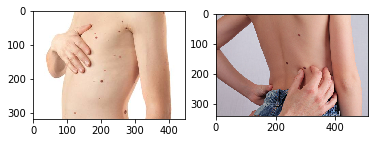

In [2]:
example_img1=plt.imread('DataBase1/14.jpg')
example_img2=plt.imread('DataBase1/176.jpg')
figure = plt.figure()
figure.add_subplot(1,2,1)
plt.imshow(example_img1)
figure.add_subplot(1,2,2)
plt.imshow(example_img2)
plt.show()

#### 1.3.2 Preprocessing

We imported the following libraries for preprocessing purposes:

In [2]:
from PIL import Image
import os
import xml.etree.ElementTree as ET

The following code iterates through our collected and labeled images. In the process we crop the moles and save them into separate files based on the previously generated .xml files. The cropped images also rescaled, thus the output images become 32x32 3-channel 8bit images in .bmp file format.

In [4]:
i_mole = 1
for i_database in range(1,3):#iterating through our databases
    for i_image in range(1,250):#iterating through the images
        if os.path.exists('DataBase%d/%d.xml' % (i_database, i_image)):#checking existance of file
            tree = ET.parse('DataBase%d/%d.xml' % (i_database, i_image))#reading the i-th .xml files
            root = tree.getroot()
            img = Image.open('DataBase%d/%d.jpg' % (i_database, i_image))#reading the i-th image
            for mole in root.findall('object'):#iterating through the labeled objects
                box = mole.find('bndbox')#acquiring the bounding box of the mole
                xmin = int(box.find('xmin').text)
                xmax = int(box.find('xmax').text)
                ymax = int(box.find('ymax').text)
                ymin = int(box.find('ymin').text)
                area = (xmin, ymin, xmax, ymax)
                cropped_img = img.crop(area)#cropping the image
                cropped_img = cropped_img.resize((32,32))#resizing the image
                cropped_img.save('Cropped/%d.bmp' % (i_mole))#saving the image
                i_mole += 1

We present two examples of the cropped moles:

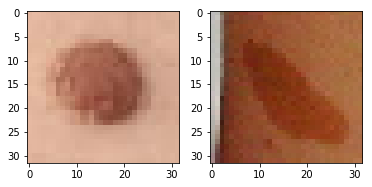

In [5]:
example_mole1=plt.imread('Cropped/8.bmp')
example_mole2=plt.imread('Cropped/810.bmp')
figure = plt.figure()
figure.add_subplot(1,2,1)
plt.imshow(example_mole1)
figure.add_subplot(1,2,2)
plt.imshow(example_mole2)
plt.show()

The following code iterates through the selected images, which will provide samples for non-mole elements. Notation for the background elements is (<i>bckg</i>). We distribute 56 points in one image evenly where we sample 32x32 regions. The cropped images checked afterwards for eliminate the unlikely events when the samples contain moles.

In [6]:
i_bckg = 1
for i_img in range(1,250):
    if os.path.exists('DataBaseBCKG/%d.jpg' % (i_img)):#checking existance of file
        img = Image.open('DataBaseBCKG/%d.jpg' % (i_img))#reading the i-th image
        width, height = img.size
        x_scale = int(width/8-1)#distance between samples in x direction
        y_scale = int(height/8-1)#distance between samples in y direction
        for x_point in range(1,8):
            for y_point in range(1,8):
                area = (x_point*x_scale-16, y_point*y_scale-16, x_point*x_scale+16, y_point*y_scale+16)#sampled area
                cropped_img = img.crop(area)#cropping the image
                cropped_img.save('CroppedBCKG/%d.bmp' % (i_bckg))#saving the image
                i_bckg += 1

We present two examples of the non-mole cropped images:

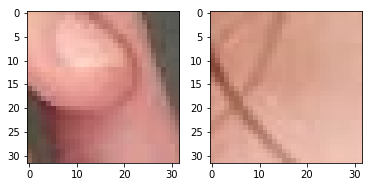

In [7]:
example_bckg1=plt.imread('CroppedBCKG/4.bmp')
example_bckg2=plt.imread('CroppedBCKG/117.bmp')
figure = plt.figure()
figure.add_subplot(1,2,1)
plt.imshow(example_bckg1)
figure.add_subplot(1,2,2)
plt.imshow(example_bckg2)
plt.show()

#### 1.3.3 Data organization and standardization

Libraries for creating the dataset:

In [3]:
import numpy as np
from random import shuffle
import glob

The following code reads the cropped images and organizes into a random sequenced tuple structure based on the label.

It is not a mole.


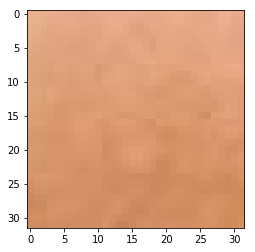

In [4]:
imgs = []
labels = []
i_file = 1
for file_path in glob.glob('Cropped/*.bmp'):  #grabbing path of the cropped images
    bckg_path = ('CroppedBCKG/%d.bmp' % i_file) #grabbing path of the background images
    if file_path and bckg_path:
        imgs.append(np.asarray(Image.open(file_path)))  #reading mole images and labels
        labels.append(1) #reading background images and labels
        imgs.append(np.asarray(Image.open(bckg_path)))  #reading mole images and labels
        labels.append(0) #reading background images and labels
    i_file += 1   

imgs = np.asarray(imgs)
labels = np.asarray(labels)
    
s = np.arange(len(imgs))
np.random.shuffle(s)
imgs = imgs[s]
labels = labels[s]

dataset = [imgs, labels]

#Example:
#Second dim: i-th image
#First dim: 0 - image data; 1 - label data
plt.imshow(dataset[0][0])
if dataset[1][0]==1:
    print('It is a mole.')
else:
    print('It is not a mole.')
    
# organize the dataset into a tuple
dataset = (dataset[0], dataset[1])

<h2 align="center">II. milestone</h2>

### 2.1 Train

Import packages for training.

In [4]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras import backend as K
from keras import regularizers
from keras.utils import np_utils

C:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### 2.1.1 preprocess
The following code separates the dataset into validation, test and train subsets. All three sets normalized.

In [6]:
# mole or not mole
nb_classes = 2

# separating inputs and outputs
X, Y = dataset

# ratio of validation samples
test_split = 0.1
valid_split = 0.1

#Indeces of the subsets
v_index = int(X.shape[0]*(1-valid_split-test_split))
t_index = int(X.shape[0]*(1-test_split))

#Splitting the dataset into test, validation and train subsets
X_train = X[:t_index].astype('float32')
Y_train = Y[:t_index]
X_valid = X[v_index:t_index].astype('float32')
Y_valid = Y[v_index:t_index]
X_test = X[t_index:].astype('float32')
Y_test = Y[t_index:]

# dimensions of our images.
img_width, img_height = X_train.shape[1], X_train.shape[2]

# normalization
X_train = X_train / 255
X_valid = X_valid / 255
X_test = X_test / 255

print('X_train max: ',X_train.max())
print('X_train min: ',X_train.min())
print('X_valid max: ',X_valid.max())
print('X_valid min: ',X_valid.min())
print('X_test max: ',X_test.max())
print('X_test min: ',X_test.min())

print('X train shape: ', X_train.shape)
print('Y train shape: ', Y_train.shape)
print('X valid shape: ', X_valid.shape)
print('Y valid shape: ', Y_valid.shape)
print('X test shape: ', X_test.shape)
print('Y test shape: ', Y_test.shape)
print(X_train.shape[0], 'train samples')

X_train max:  1.0
X_train min:  0.0
X_valid max:  1.0
X_valid min:  0.0
X_test max:  1.0
X_test min:  0.0
X train shape:  (2514, 32, 32, 3)
Y train shape:  (2514,)
X valid shape:  (279, 32, 32, 3)
Y valid shape:  (279,)
X test shape:  (280, 32, 32, 3)
Y test shape:  (280,)
2514 train samples


One-hot encoding & checking channel format.

In [7]:
# convert class vectors to binary class matrices:
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_valid = np_utils.to_categorical(Y_valid, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_width, img_height)
    X_valid = X_valid.reshape(X_valid.shape[0], 3, img_width, img_height)
    X_test = X_test.reshape(X_test.shape[0], 3, img_width, img_height)
    input_shape = (3, img_width, img_height)
else:
    X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 3)
    X_valid = X_valid.reshape(X_valid.shape[0], img_width, img_height, 3)
    X_test = X_test.reshape(X_test.shape[0], img_width, img_height, 3)
    input_shape = (img_width, img_height, 3)

#### 2.1.2 Define CNN

The block below shows the model we have trained. It has three convolution layers with ReLU activation followed by maxpooling layers then a single Dense layer with two outputs. The latter has a sigmoid activation and we used L2 regulization in this layer as well.

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(nb_classes, activation='sigmoid',
                kernel_regularizer=regularizers.l2(0.0001)
               ))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
__________

#### 2.1.3 Train

Early stopping was set up as seen below, so we can load the best model always back. Besides that batch size and number of epochs were defined.

In [9]:
batch_size = 16
epochs = 100

# Next, setting the early stopping
# and define checkpoint, so we can load the best state back
patience=40
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='cnn_weights.hdf5', save_best_only=True, verbose=1)

network_history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_valid, Y_valid),
          callbacks=[checkpointer, early_stopping])

Train on 2514 samples, validate on 279 samples
Epoch 1/100
2514/2514 [==============================] - 89s 35ms/step - loss: 0.4826 - acc: 0.7486 - val_loss: 0.3457 - val_acc: 0.8423

Epoch 00001: val_loss improved from inf to 0.34568, saving model to cnn_weights.hdf5
Epoch 2/100
 160/2514 [>.............................] - ETA: 1:18 - loss: 0.3477 - acc: 0.8562

KeyboardInterrupt: 

### 2.2 Results

In this section we visualised the training process and the results of the trained model.

In [55]:
def plot_history(network_history):
    figure = plt.figure(figsize=(20,20))
    figure.add_subplot(2,1,1)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'], fontsize=18)

    figure.add_subplot(2,1,2)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'])
    
    plt.show()

Plots below show loesses (upper plot) and accuracy (lower plot) during the training process.

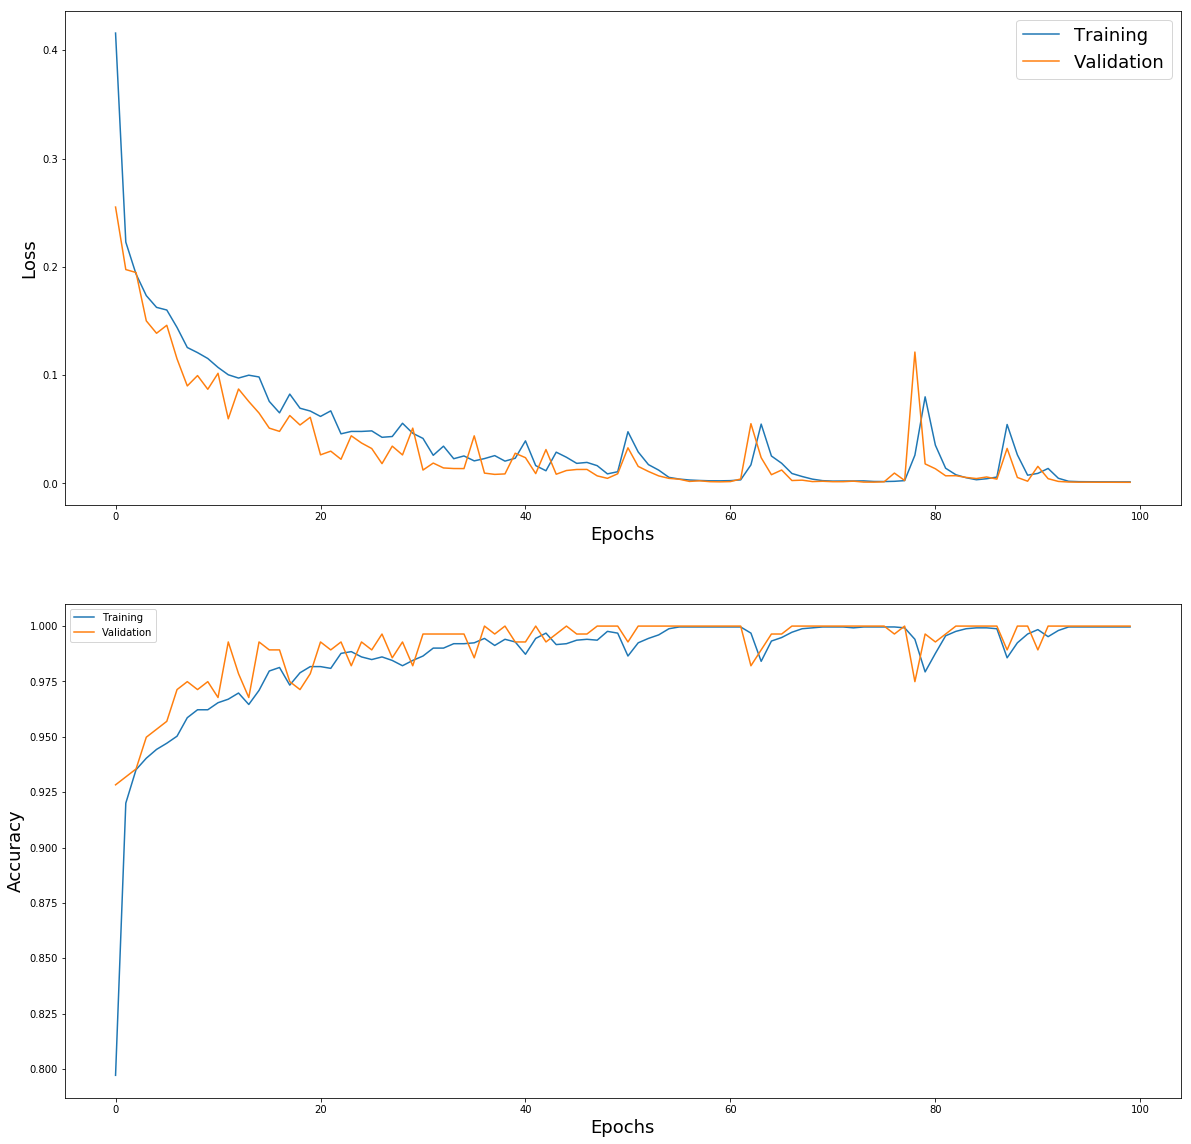

In [56]:
plot_history(network_history)

Next, load best model back and make a prediction.

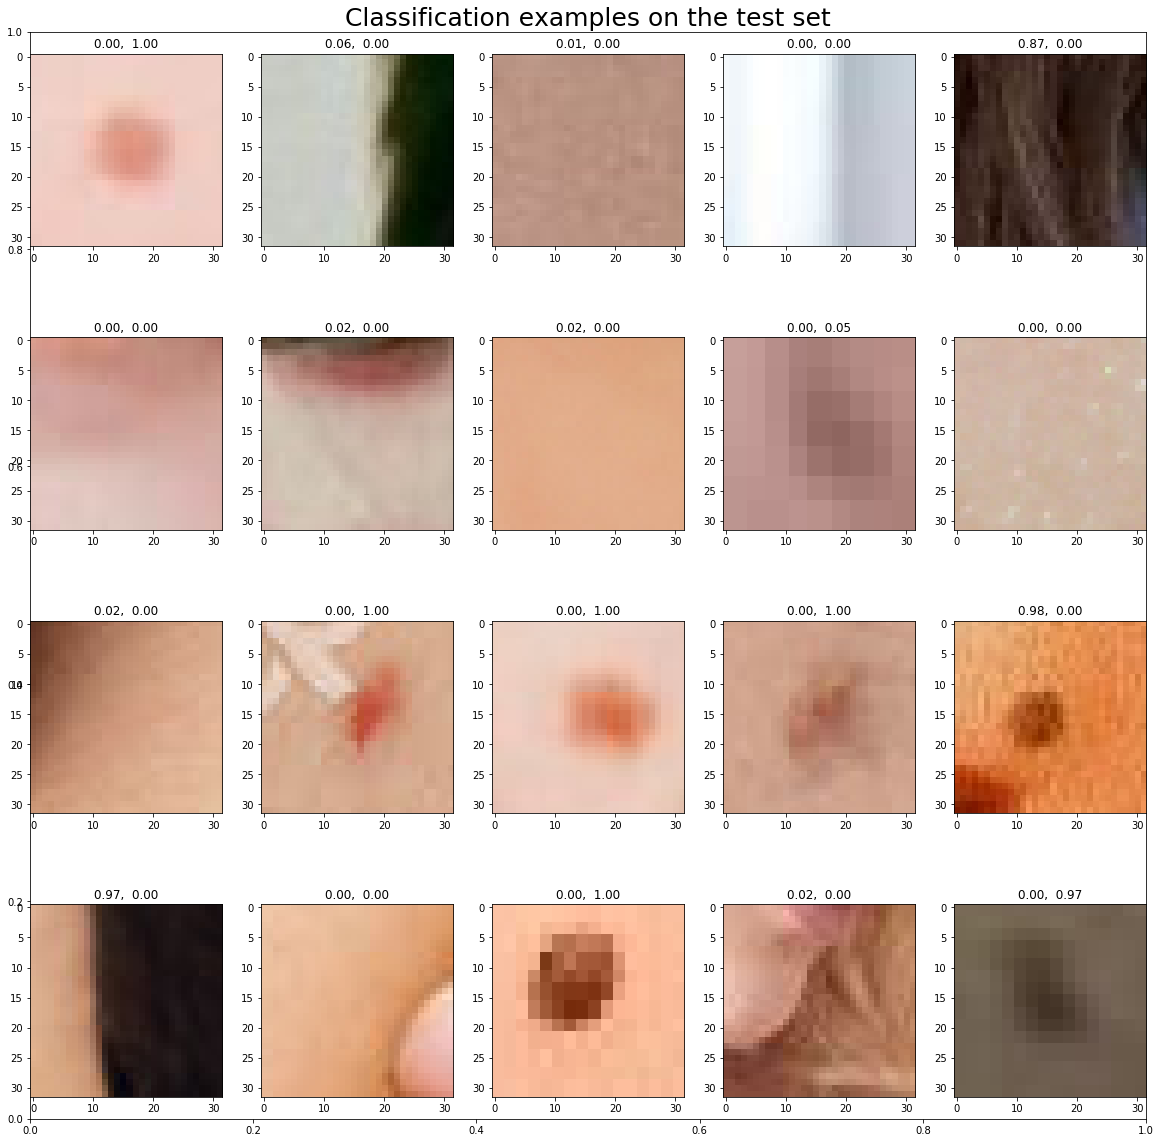

In [10]:
model = load_model('cnn_weights.hdf5')
pred = model.predict(X_test[:20])  # we show the first 20 elements of the test set

i=0
figure = plt.figure(figsize=(20,20))
plt.title("Classification examples on the test set", fontsize=25)

for value in pred:
    title = str("%0.2f" % np.asscalar(value[0])) + ',  ' + str("%0.2f" % np.asscalar(value[1]))
    figure.add_subplot(4,5,i+1)
    plt.imshow(X_test[i])
    plt.title(title)
    i+=1

plt.show()

### 2.3 Object detector

In [5]:
from scipy import misc as msc
from sklearn.metrics import mean_squared_error
import matplotlib.patches as patches

The following code slices the image under diagnoses into smaller parts with different shifts in both x and y directions and with different window sizes. The input for the classificator CNN is a 32 x 32 3-channel image. The idea was to start with a 32x32 window and double the size after a segmentation is completed. For one segmentation cycle the window is shifted by one-third of the window size in each iteration in x and y direction separately.
The code is also responsible for creating an instruction matrix, which links the input image to the corresponding image position and bounding box size.

In [14]:
shift = np.array([10,20,40], dtype=np.uint8) #window shifted by number of pixels
size = np.array([32,64,128], dtype=np.uint8) #window sizes in pixels

uniform_size = 32 #input size of the classificator CNN
i = 0

for i_shift, i_size in zip(shift, size): #linking the two jointly changed parameters
    for step_y in range(0,3): #shifting the slicing grid in y direction
        for step_x in range(0,3): #shifting the slicing grid in x direction
            diagimg = np.asarray(Image.open('DataBase1/3.jpg')) #reading the currently diagnosed input image
            diagimg = diagimg[i_shift*step_y:, i_shift*step_x:]  #shifting the image according to the corresponding parameters
            grid = diagimg[0:(diagimg.shape[0]//i_size)*i_size, 0:(diagimg.shape[1]//i_size)*i_size] #cropping the image to fit even windows
            grid_sliced = np.asarray(np.split(grid, grid.shape[0]//i_size, axis = 0)) #slicing the image in y direction
            grid_sliced = np.asarray(np.split(grid_sliced, grid_sliced.shape[2]//i_size, axis = 2)) #slicing the image in x direction
            grid_sliced = np.reshape(grid_sliced, (grid_sliced.shape[0]*grid_sliced.shape[1], i_size, i_size, 3)) #reshaping the image into a column array each row containing a sliced window
            
            vector_x = np.arange(i_shift*step_x, grid.shape[1], i_size) #getting the window positions in x direction
            vector_y = np.arange(i_shift*step_y, grid.shape[0], i_size) #getting the window positions in y direction
            matrix = np.asarray(np.meshgrid(vector_x, vector_y, sparse=False, indexing='ij')) #creating the window position matrix
            info_img = np.transpose(np.reshape(matrix, (2,matrix.shape[1]*matrix.shape[2]))) #reshaping the window position matrix into a column array, each row containing the position of the correspondig sliced window
            info_img = np.concatenate((info_img, np.multiply(i_size,np.ones((info_img.shape[0],1)))), axis=1) #adding the size of the windows to the column array as plus information
            
            if i_size > uniform_size:
                out_shape = grid_sliced.shape[0], uniform_size, grid_sliced.shape[1]//uniform_size, uniform_size, grid_sliced.shape[2]//uniform_size, 3 #defining the expected image size for the CNN
                grid_sliced = grid_sliced.reshape(out_shape).mean(2).mean(3) #resizing the images according to the expected shape for the CNN
            if i==0:
                input_sequence = grid_sliced
                info = info_img
                i += 1
            else:
                input_sequence = np.append(input_sequence, grid_sliced, axis = 0) #extending the input_sequence with the current new inputs
                info = np.vstack((info,info_img)) #extending the information array with the current new information
                i += 1

print(input_sequence.shape)
print(info.shape)

info[:, 0], info[:, 1] = info[:, 1], info[:, 0].copy() #changing the order of the x and y positions of the windows

input_sequence_scaled = input_sequence/255 #normalizing the input images

(22826, 32, 32, 3)
(22826, 3)


In [10]:
model = load_model('cnn_weights.hdf5')
preds = model.predict(input_sequence_scaled)
count=0

[1.6082804e-09 9.9987411e-01]
Press Enter to continue...


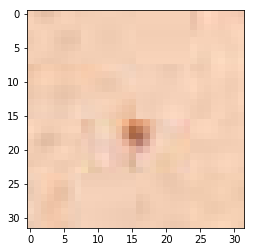

[6.5016093e-33 9.6060884e-01]
Press Enter to continue...


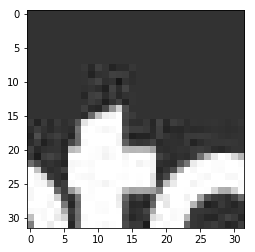

[1.3065131e-09 8.3884400e-01]
Press Enter to continue...


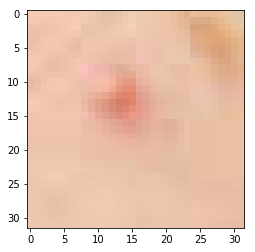

[8.500033e-11 9.999957e-01]
Press Enter to continue...


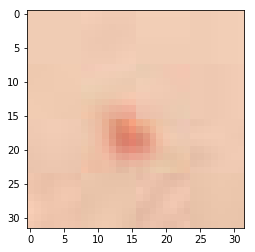

[2.7212803e-07 9.4517398e-01]
Press Enter to continue...


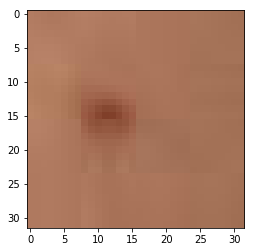

[2.9340987e-12 9.9956948e-01]
Press Enter to continue...


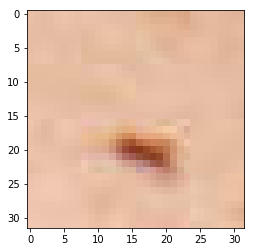

[3.4351215e-12 1.0000000e+00]
Press Enter to continue...


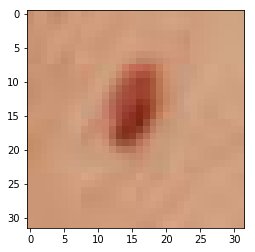

[3.0936339e-12 1.0000000e+00]
Press Enter to continue...


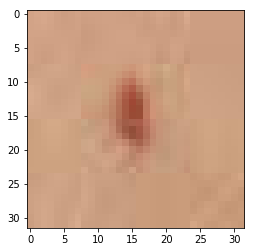

[1.8521446e-08 9.9938858e-01]
Press Enter to continue...


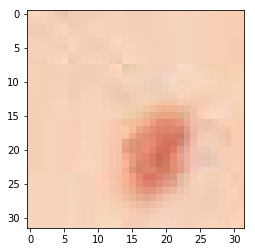

[8.177897e-07 7.644454e-01]
Press Enter to continue...


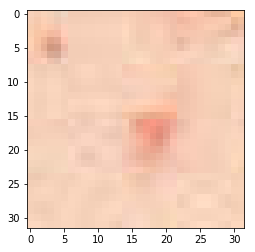

[1.7598715e-06 9.9998605e-01]
Press Enter to continue...


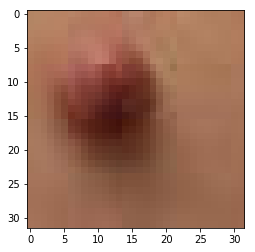

[1.2045746e-08 9.8442078e-01]
Press Enter to continue...


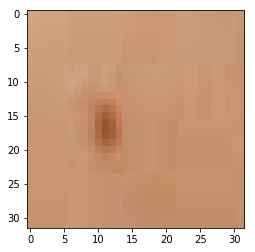

[6.484662e-12 9.997631e-01]
Press Enter to continue...


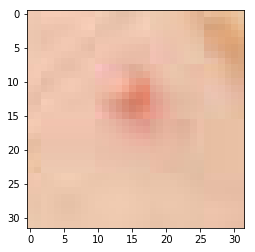

[2.0519122e-09 9.9999630e-01]
Press Enter to continue...


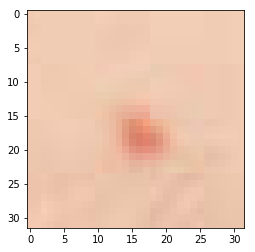

[2.0717016e-06 9.6775025e-01]
Press Enter to continue...


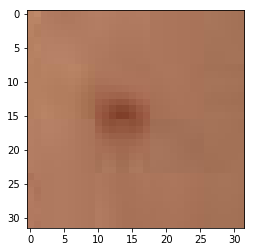

[2.2694322e-09 9.5143408e-01]
Press Enter to continue...


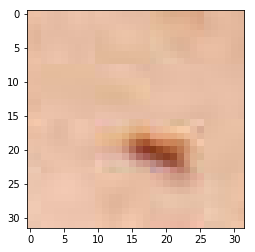

[5.439323e-12 6.270631e-01]
Press Enter to continue...


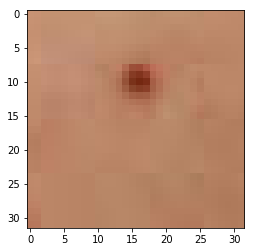

[9.701901e-11 1.000000e+00]
Press Enter to continue...


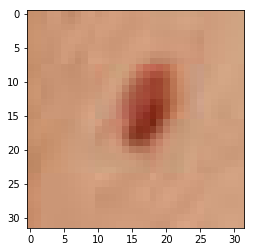

[1.2025944e-10 9.9999988e-01]
Press Enter to continue...


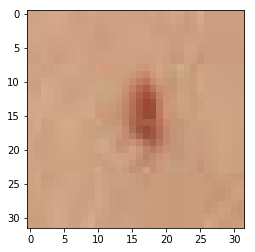

[9.105772e-14 9.983828e-01]
Press Enter to continue...


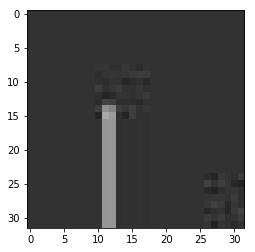

[6.4660513e-15 9.1831148e-01]
Press Enter to continue...


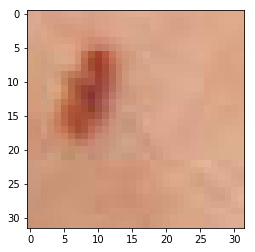

[5.9450056e-10 9.9004233e-01]
Press Enter to continue...


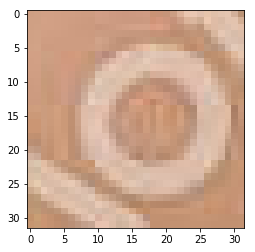

[2.128489e-09 9.994436e-01]
Press Enter to continue...


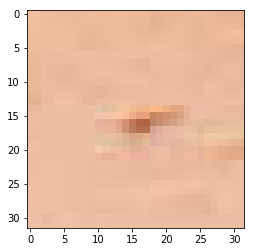

[6.4634968e-12 9.9272996e-01]
Press Enter to continue...


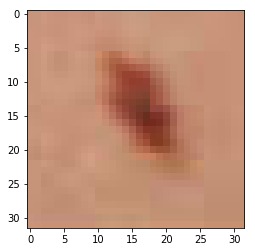

[3.5030973e-10 7.1202803e-01]
Press Enter to continue...


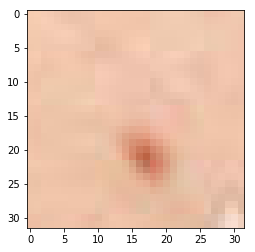

[0.         0.99994826]
Press Enter to continue...


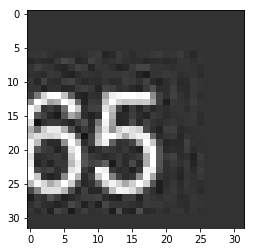

[4.945096e-11 1.000000e+00]
Press Enter to continue...


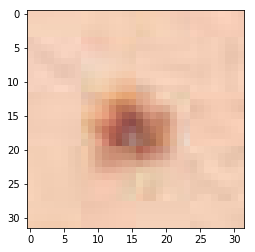

[2.2854529e-05 9.7908562e-01]
Press Enter to continue...


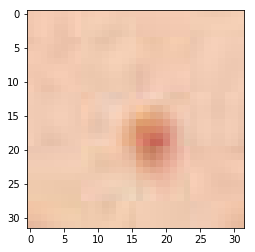

[1.1656591e-10 9.9999714e-01]
Press Enter to continue...


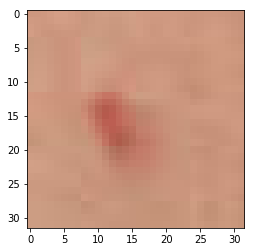

[1.31599055e-11 9.99999404e-01]
Press Enter to continue...


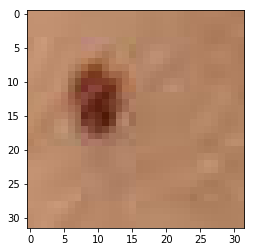

[1.4357719e-10 9.9875915e-01]
Press Enter to continue...


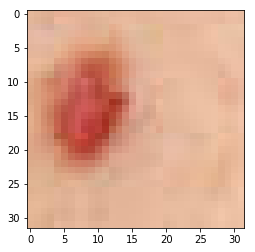

[7.6229564e-11 9.9997139e-01]
Press Enter to continue...


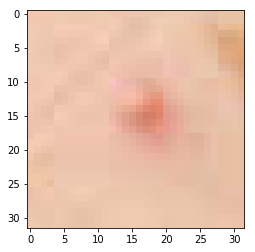

[5.1894073e-08 8.9143258e-01]
Press Enter to continue...


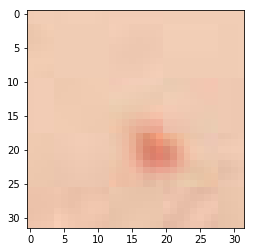

[2.2747677e-06 9.9882537e-01]
Press Enter to continue...


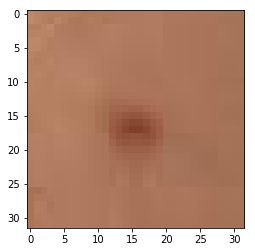

[2.4605035e-06 7.5370210e-01]
Press Enter to continue...


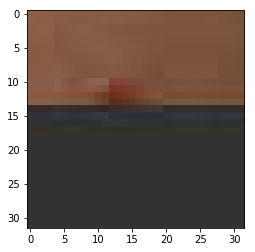

[4.7984307e-11 9.9999988e-01]
Press Enter to continue...


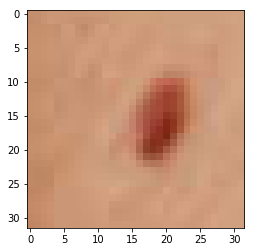

[1.8324730e-09 9.9978024e-01]
Press Enter to continue...


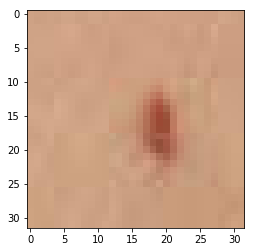

[8.9094176e-19 9.9999225e-01]
Press Enter to continue...


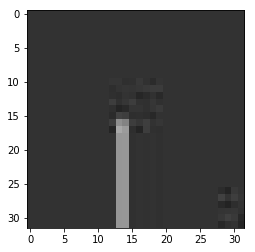

[1.5774125e-11 9.9997902e-01]
Press Enter to continue...


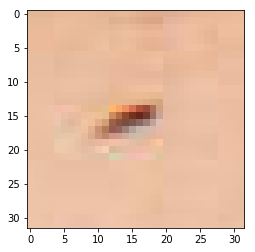

[1.6535123e-10 9.8799127e-01]
Press Enter to continue...


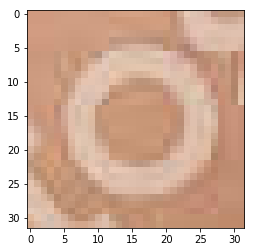

[2.8884192e-33 9.9890137e-01]
Press Enter to continue...


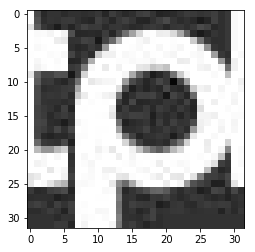

[1.5884962e-07 9.9973661e-01]
Press Enter to continue...


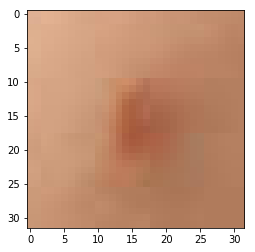

[8.6274383e-07 8.5791528e-01]
Press Enter to continue...


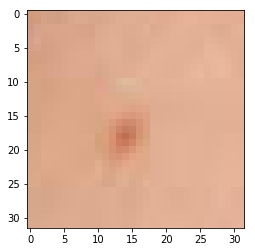

[0.35627374 0.76058424]
Press Enter to continue...


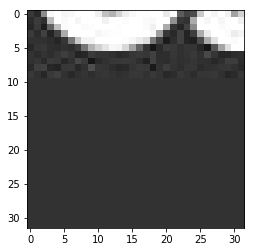

[6.7871403e-11 9.8851305e-01]
Press Enter to continue...


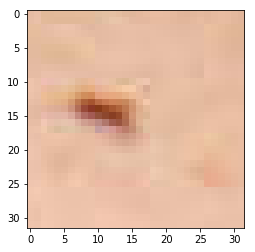

[8.0627598e-07 9.9894387e-01]
Press Enter to continue...


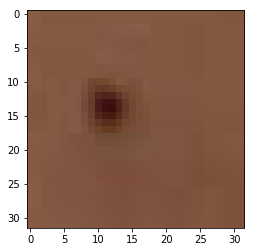

[1.9893251e-34 9.9999523e-01]
Press Enter to continue...


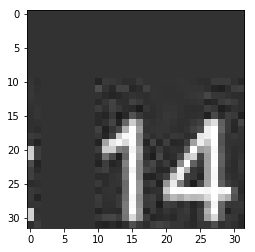

[2.5571798e-09 9.9803036e-01]
Press Enter to continue...


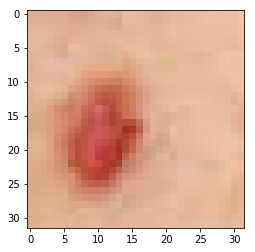

[3.147608e-11 9.995253e-01]
Press Enter to continue...


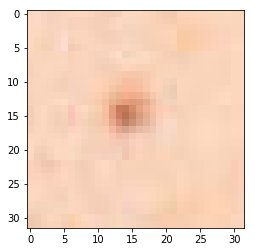

[2.7323885e-12 9.9999583e-01]
Press Enter to continue...


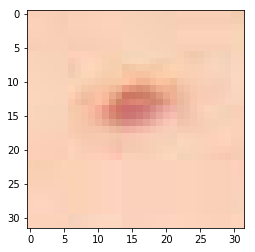

[2.6946823e-10 9.9995017e-01]
Press Enter to continue...


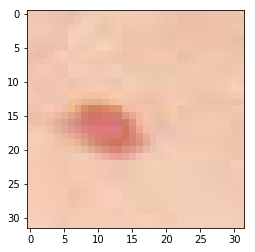

[4.2097867e-08 6.7729908e-01]
Press Enter to continue...


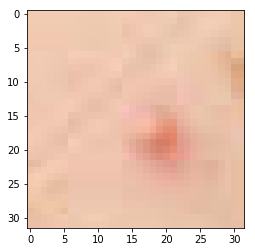

[2.5573466e-04 5.7191920e-01]
Press Enter to continue...


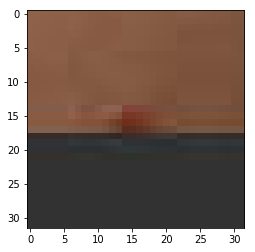

[1.4966346e-08 9.7406572e-01]
Press Enter to continue...


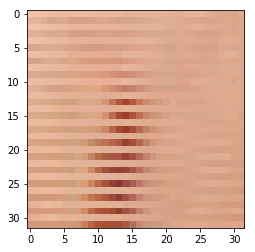

[1.4557202e-13 1.0000000e+00]
Press Enter to continue...


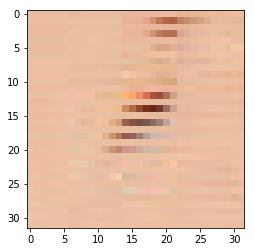

[1.1545456e-12 8.2638294e-01]
Press Enter to continue...


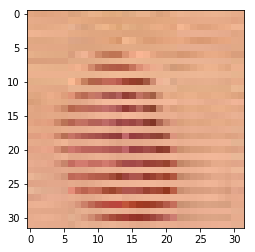

[1.0459782e-11 9.9264812e-01]
Press Enter to continue...


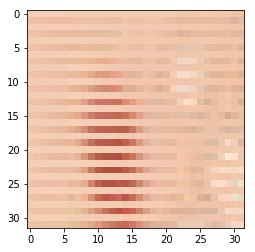

[3.8316563e-09 6.1444229e-01]
Press Enter to continue...


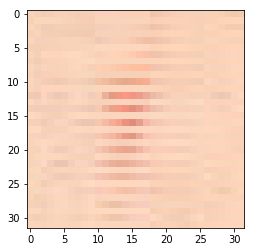

[1.3065349e-10 9.9998605e-01]
Press Enter to continue...


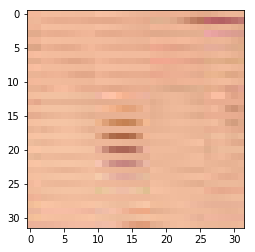

[2.0870713e-11 9.6616036e-01]
Press Enter to continue...


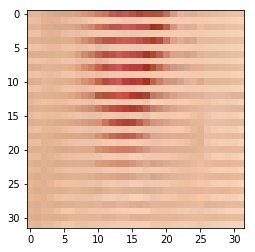

[5.730924e-14 8.393837e-01]
Press Enter to continue...


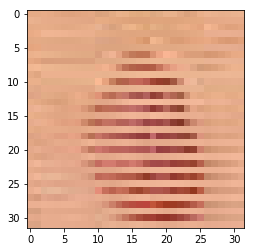

[4.8784197e-12 9.9935025e-01]
Press Enter to continue...


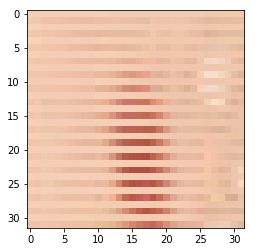

[9.0635076e-11 9.5825583e-01]
Press Enter to continue...


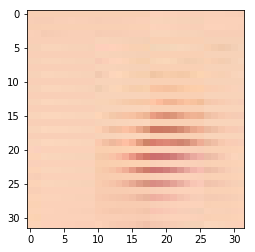

[2.2218853e-13 9.9807966e-01]
Press Enter to continue...


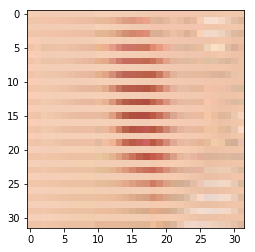

[1.0240458e-16 1.0000000e+00]
Press Enter to continue...


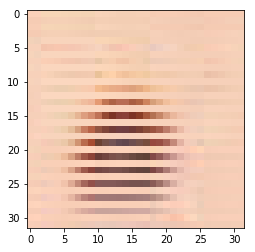

[1.2261445e-11 6.9714397e-01]
Press Enter to continue...


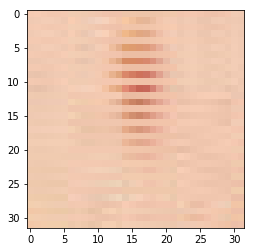

[1.2921059e-11 9.9994349e-01]
Press Enter to continue...


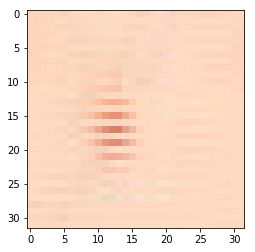

[1.0750558e-11 9.6014345e-01]
Press Enter to continue...


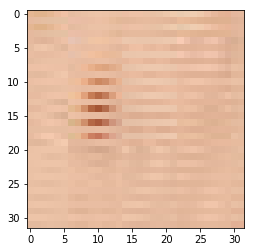

[5.930988e-20 1.000000e+00]
Press Enter to continue...


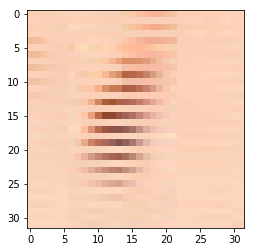

[8.019521e-15 1.000000e+00]
Press Enter to continue...


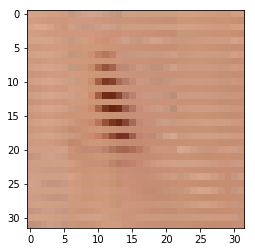

[2.9779984e-15 1.0000000e+00]
Press Enter to continue...


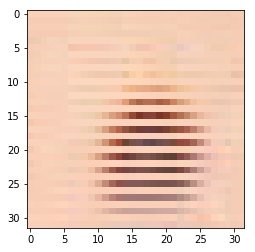

[7.9367225e-12 9.4953358e-01]
Press Enter to continue...


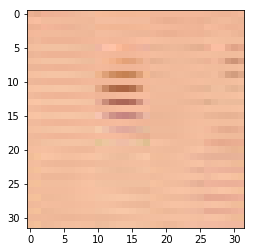

[1.7733906e-11 9.9943763e-01]
Press Enter to continue...


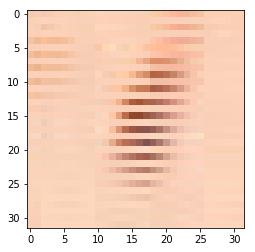

[1.7473283e-12 9.9999988e-01]
Press Enter to continue...


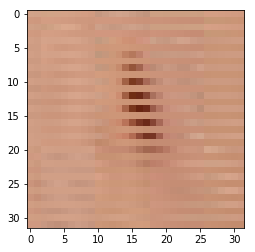

In [122]:
for i in range(0,preds.shape[0]):
    if preds[i,1] > 0.5:
        count+=1
        figure = plt.figure()
        plt.imshow(input_sequence[i,:,:,:])
        print(preds[i])
        input("Press Enter to continue...")
        plt.show()

In [83]:
print('Megtalált anyajegyek a képen:',count)

Megtalált anyajegyek a képen: 74


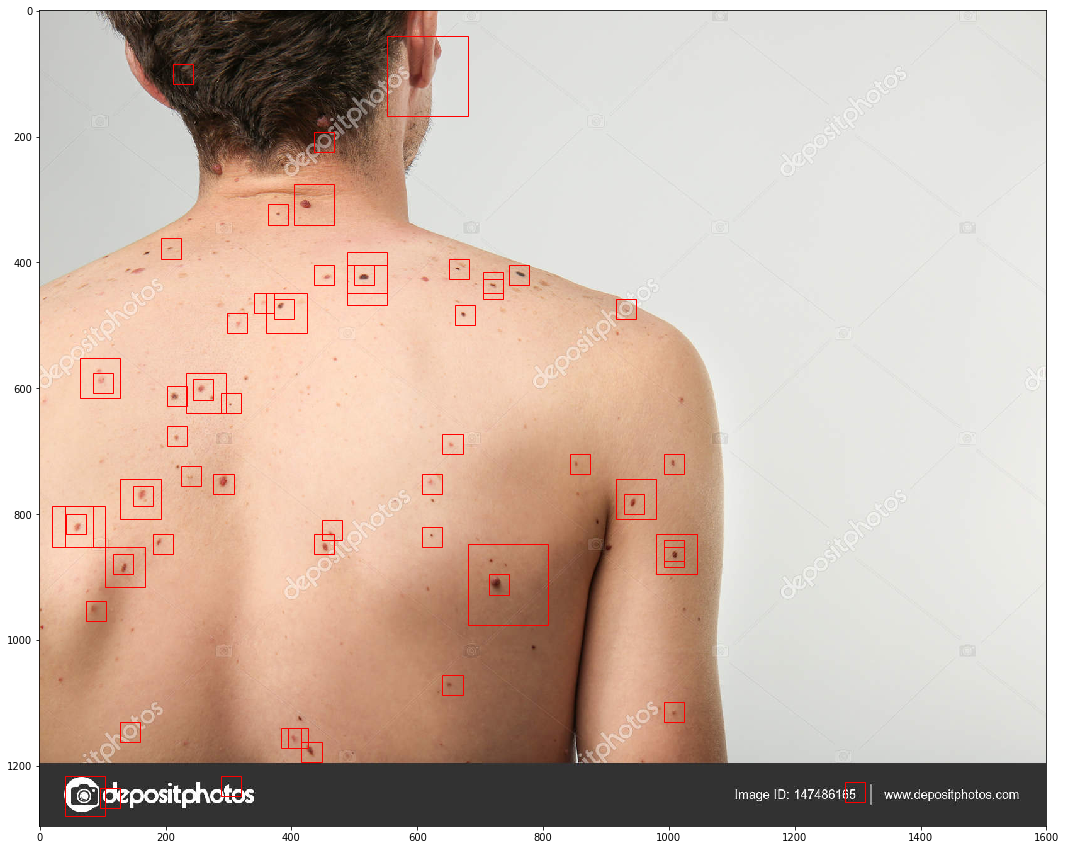

In [11]:
diagimg = np.asarray(Image.open('DataBase1/3.jpg'))

#figure = plt.figure()
fig,ax = plt.subplots(1,figsize=(25,15))
ax.imshow(diagimg)

for i in range(0,preds.shape[0]):
    if preds[i,1] > 0.5:
        rect = patches.Rectangle((info[i,1],info[i,0]),info[i,2],info[i,2],linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
plt.show()